#### Min-Cut: Flow Network

Implementation of a method for computing a global min-cut of a connected undirected graph based on the Ford-Fulkerson algorithm.

In [39]:
# use BFS to find path from s to t in Gf
def find_st_path(adjacency_list, s, t):
    assert (s >= 0 and s < len(adjacency_list)), "s is out of range"
    # initialize all vertices as undiscovered except for s
    discovered = [False] * len(adjacency_list)
    discovered[s] = True
    parent = [None] * len(adjacency_list)
    # intiialize BFS queue
    Q = []
    Q.append(s)
    # initialize s-t path
    path = []
    # run BFS
    while len(Q)>0:
        # pop vertex from front of queue
        u = Q.pop(0)
        # find vertices adjacent to u and add them to the Q if they are undiscovered
        for (v,ce) in adjacency_list[u]:
            if not discovered[v]:
                discovered[v] = True
                parent[v] = (u, ce)
                # if v is t, then we have found the path
                if v == t:
                    # reconstruct path from s to t following parent pointers
                    while parent[t] != None:
                        # add edge to path
                        edge = (parent[t][0], t, parent[t][1])
                        path.append(edge)
                        t = parent[t][0]
                    return path, discovered
                # add to Q
                Q.append(v)
 
    # if we reach here, then there is no s-t path
    return path, discovered            

def construct_residual_graph(adjacency_list, flow):
    Gf_adjacency_list = {u:[] for u in adjacency_list.keys()}
    for u in range(len(adjacency_list)):
        for v in adjacency_list[u]:
            # add forward edge if there's non-zero residual capacity
            residual_ce = 1 - flow[(u, v)]
            if residual_ce > 0:
                Gf_adjacency_list[u].append((v, residual_ce))
            # add backward edge if there's non-zero flow 
            if flow[(u, v)] > 0:
                Gf_adjacency_list[v].append((u, flow[(u, v)]))

    return Gf_adjacency_list            

def FF_nosclaing(adjacency_list, s, t, verbose=False):
    # create copy of adjacency list
    adjacency_list = {u:list(adjacency_list[u]) for u in adjacency_list.keys()}
    # delete incoming edges to s 
    for u in adjacency_list[s]:
        adjacency_list[u].remove(s)
    # delete outgoing edges from t
    adjacency_list[t] = []    
            
    # all edges have capacity of 1 
    ce = 1
    # initialize the flow to 0
    flow = {}
    capacity = {}
    for u in adjacency_list.keys():
        for v in adjacency_list[u]:
            flow[(u, v)] = 0
            capacity[(u, v)] = ce

    # construct residual graph
    Gf_adjacency_list = construct_residual_graph(adjacency_list, flow)
    if verbose:
        print("Initial residual graph:")
        print(Gf_adjacency_list)

    num_iterations = 0
    # run augmenting iterations
    while True:
        # find s-t path in Gf
        path, discovered = find_st_path(Gf_adjacency_list, s, t)
        # if there is no s-t path, then we are done
        if len(path) == 0:
            # extract min-cut(A, B) from discovered vertices
            A = [u for u in range(len(discovered)) if discovered[u]]
            B = [u for u in range(len(discovered)) if not discovered[u]]    
            mincut = []
            for u in A:
                for v in adjacency_list[u]:
                    if v in B:
                        mincut.append((u, v))
            if verbose:
                flow_value = sum([flow[(s, v)] for v in adjacency_list[s]])
                print(f"\nMax flow found! |f| = {flow_value}, total iterations = {num_iterations}")
                print(f"Min-cut: {mincut}")            
            return mincut
        
        else:
            # find bottleneck capacity of path
            bottleneck_capacity = float('inf')
            for (u, v, ce) in path:
                if ce < bottleneck_capacity:
                    bottleneck_capacity = ce
            # augment flow along path
            for (u, v, ce) in path:
                if (u, v) in capacity:
                    # increase flow along forward edge (u, v)
                    flow[(u, v)] += bottleneck_capacity
                else:
                    # decrease flow along backward edge (v, u)
                    flow[(v, u)] -= bottleneck_capacity 
            # construct updated residual graph        
            Gf_adjacency_list = construct_residual_graph(adjacency_list, flow)     
            
            if verbose:
                print(f"\nFlow augmented along path: {path} by amount: {bottleneck_capacity}")
                print(f"New residual graph: \n {Gf_adjacency_list}")
                print(f"Augmented Flow: \n {flow}")   

            num_iterations += 1        

def FF_min_cut(adjacency_list, verbose=False):
    # pick an s
    s = 0
    # find min-cut for each possible t
    global_min_cut = None
    for t in range(1, len(adjacency_list)):
        mincut = FF_nosclaing(adjacency_list, s, t)
        if global_min_cut == None or len(mincut) < len(global_min_cut):
            global_min_cut = mincut

    if verbose:
        print(f"Global min-cut: {global_min_cut}")

    return global_min_cut    


In [40]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_graph(adjacency_list, fig_size=5):
    adjacency_list = list(adjacency_list.values())
    # Create a new graph
    G = nx.Graph()

    # Add edges to the graph
    for node, neighbours in enumerate(adjacency_list):
        for neighbour in neighbours:
            G.add_edge(node, neighbour)

    # Draw the graph
    plt.figure(figsize=(fig_size, fig_size))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True)
    plt.show()

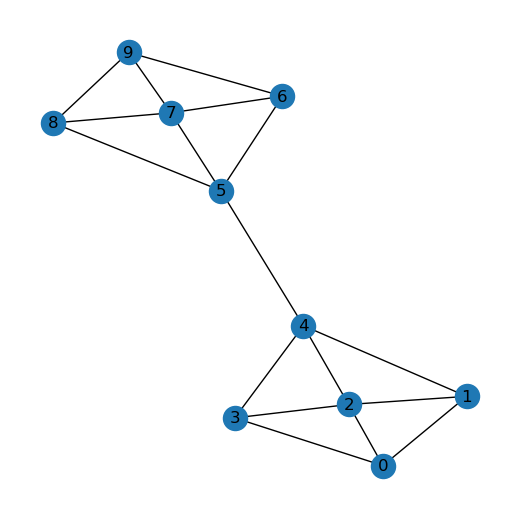

Global min-cut: [(4, 5)]


In [44]:
# larger example graph
adjacency_list = {0:[1,2,3], 1:[0,2,4], 2:[0,1,3,4], 3:[0,2,4], 4:[1,2,3,5], 5:[4,6,7,8], 6:[5,7,9], 7:[5,6,8,9], 8:[5,7,9], 9:[6,7,8]}
plot_graph(adjacency_list, fig_size=5)

# find global min-cut
global_mincut = FF_min_cut(adjacency_list, verbose=True)